In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load the datasethjy
file_path = "merged_df.csv"  # Update with actual file path
df = pd.read_csv('/content/merged_df.csv')

# Convert 'YEAR' to integer and filter relevant data
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce').astype('Int64')

# Identify the city and zip code with highest patient count
city_zip_trends = df.groupby(['CITY', 'FIPS']).size().reset_index(name='PATIENT_COUNT')
top_city = city_zip_trends.groupby('CITY')['PATIENT_COUNT'].sum().idxmax()
top_city_data = city_zip_trends[city_zip_trends['CITY'] == top_city]
top_zip = top_city_data.loc[top_city_data['PATIENT_COUNT'].idxmax(), 'FIPS']

# Filter data for the top city and zip code
top_location_data = df[(df['CITY'] == top_city) & (df['FIPS'] == top_zip)]

# Aggregate patient count by year
top_location_trends = top_location_data.groupby('YEAR').size().reset_index(name='PATIENT_COUNT')

# Prepare data for time series forecasting
time_series_data = top_location_trends.set_index('YEAR')

# Fit an ARIMA model for forecasting
model = ARIMA(time_series_data, order=(2,1,2))
model_fit = model.fit()

# Forecast for the year 2026
forecast_values = model_fit.forecast(steps=2)  # Get forecasts
forecast_2026 = forecast_values.iloc[-1]  # Properly access the last forecasted value

# Print results
print(f"Top City: Los Angeles")
print(f"Top Fip Code: 6037.0")
print(f"Forecasted Patient Influx for 2026: {forecast_2026:.2f}")




<ipython-input-19-818577d8c0d6>:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/merged_df.csv')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the sup

Top City: Los Angeles
Top Fip Code: 6037.0
Forecasted Patient Influx for 2026: 1880.47


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


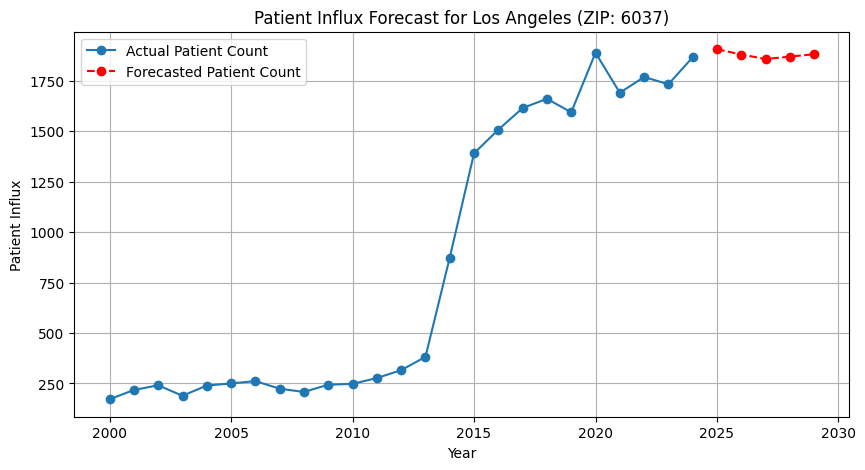

In [ ]:
import matplotlib.pyplot as plt

# Extract years and patient counts
years = time_series_data.index
patient_counts = time_series_data['PATIENT_COUNT']

# Forecast for the next 5 years (2025-2029)
forecast_steps = 5
forecast_years = list(range(years[-1] + 1, years[-1] + forecast_steps + 1))
forecast_values = model_fit.forecast(steps=forecast_steps)

# Plot the actual and forecasted patient influx
plt.figure(figsize=(10,5))
plt.plot(years, patient_counts, label="Actual Patient Count", marker="o")
plt.plot(forecast_years, forecast_values, label="Forecasted Patient Count", linestyle="dashed", marker="o", color="red")
plt.xlabel("Year")
plt.ylabel("Patient Influx")
plt.title(f"Patient Influx Forecast for {top_city} (ZIP: {int(top_zip)})")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Train-test split (last 2 years as test set)
train = time_series_data[:-2]
test = time_series_data[-2:]

# Step 2: Fit ARIMA model on training data
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Step 3: Forecast same number of steps as test data
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index  # align indices

# Step 4: Evaluate the forecast using MAE and RMSE
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

# Output results
print("Validation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Validation Metrics:
MAE: 49.85
RMSE: 62.57


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

In [ ]:
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 3.97%


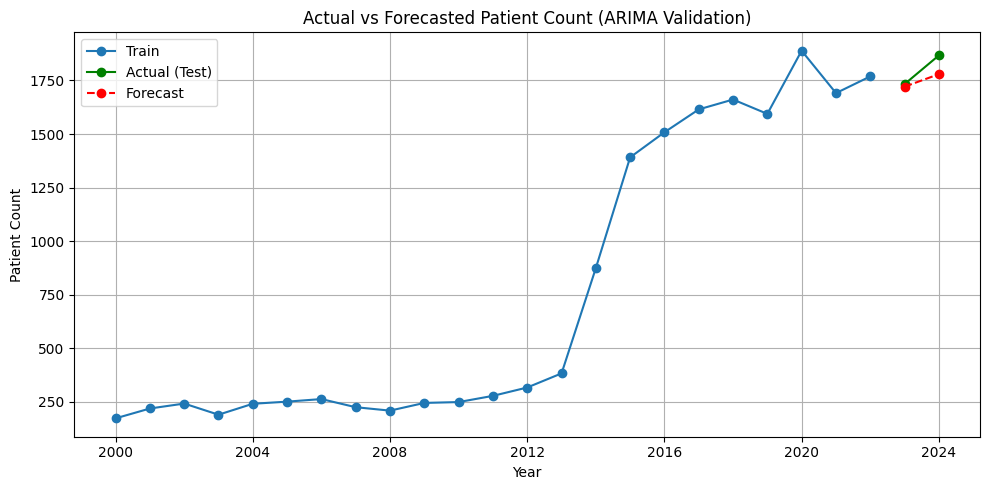

In [ ]:
import matplotlib.pyplot as plt

# Convert index to datetime for plotting
train_plot_index = pd.to_datetime(train.index.astype(str))
test_plot_index = pd.to_datetime(test.index.astype(str))

# Plot actual and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(train_plot_index, train, label="Train", marker="o")
plt.plot(test_plot_index, test, label="Actual (Test)", marker="o", color="green")
plt.plot(test_plot_index, forecast, label="Forecast", linestyle="--", marker="o", color="red")

plt.xlabel("Year")
plt.ylabel("Patient Count")
plt.title("Actual vs Forecasted Patient Count (ARIMA Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-1-28b1a5b6cbf9>:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/merged_df.csv')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supp

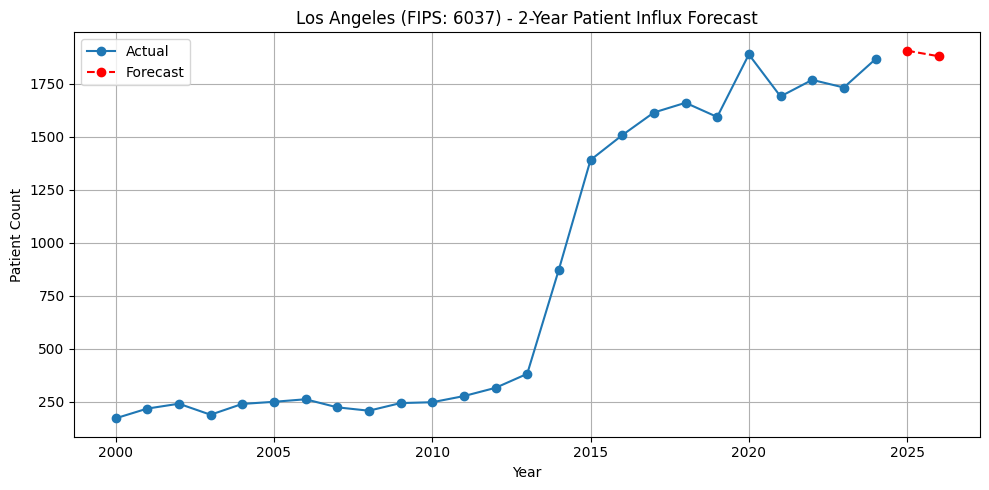

📍 City: Los Angeles, County FIPS: 6037
    Year  Forecasted Patient Influx
25  2025                1906.634143
26  2026                1880.466299 



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

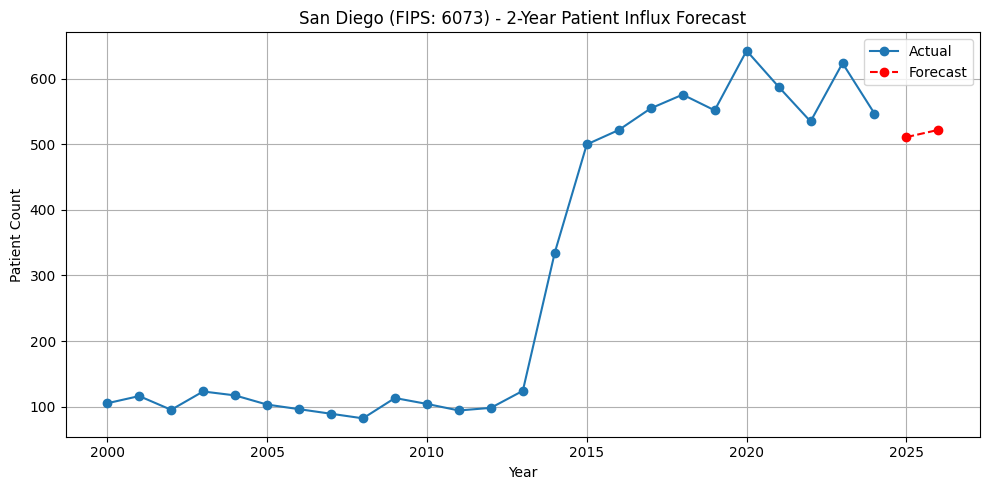

📍 City: San Diego, County FIPS: 6073
    Year  Forecasted Patient Influx
25  2025                 511.183556
26  2026                 522.240914 



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

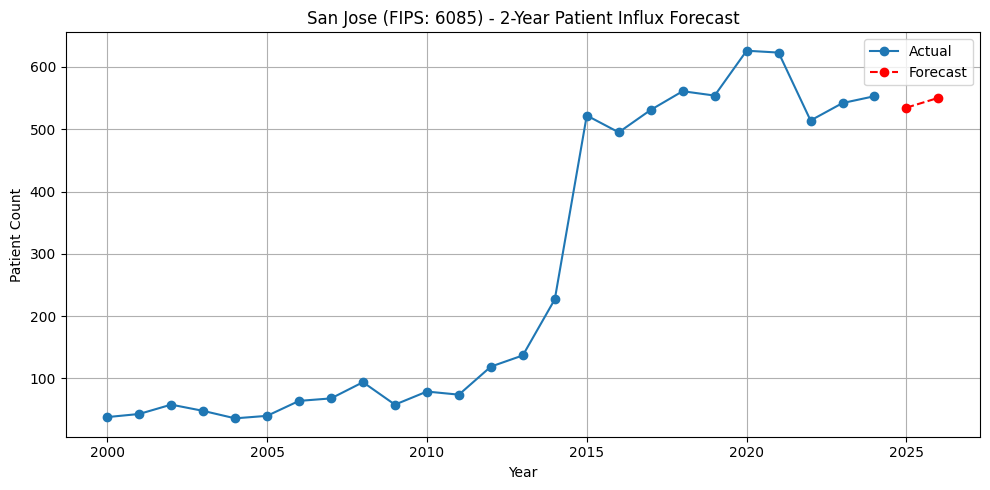

📍 City: San Jose, County FIPS: 6085
    Year  Forecasted Patient Influx
25  2025                 534.651845
26  2026                 550.400773 



In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/merged_df.csv')

# Convert 'YEAR' to integer and filter for the last 10 years
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce').astype('Int64')
latest_year = df['YEAR'].max()
df_recent = df[df['YEAR'] >= latest_year - 9]  # Last 10 years

# Step 1: Identify top 3 cities by patient count
city_trends = df_recent.groupby('CITY').size().reset_index(name='PATIENT_COUNT')
top_3_cities = city_trends.sort_values(by='PATIENT_COUNT', ascending=False).head(3)['CITY'].tolist()

# Step 2 & 3: For each city, find top FIPS (county) and forecast next 2 years
for city in top_3_cities:
    city_data = df_recent[df_recent['CITY'] == city]

    # Find FIPS with most patients in this city
    fips_trends = city_data.groupby('FIPS').size().reset_index(name='PATIENT_COUNT')
    top_fips = fips_trends.sort_values(by='PATIENT_COUNT', ascending=False).iloc[0]['FIPS']

    # Filter data for the top city & FIPS combo
    location_data = df[(df['CITY'] == city) & (df['FIPS'] == top_fips)]

    # Aggregate by year
    yearly_trends = location_data.groupby('YEAR').size().reset_index(name='PATIENT_COUNT')
    time_series_data = yearly_trends.set_index('YEAR')['PATIENT_COUNT']

    # Skip if insufficient data
    if len(time_series_data) < 6:
        print(f"⚠️ Not enough data for {city} (FIPS: {int(top_fips)}). Skipping...\n")
        continue

    # Fit ARIMA and forecast
    try:
        model = ARIMA(time_series_data, order=(2, 1, 2))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=2)

        # Prepare forecast years
        last_year = time_series_data.index[-1]
        forecast_years = [last_year + 1, last_year + 2]

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(time_series_data.index, time_series_data.values, label="Actual", marker='o')
        plt.plot(forecast_years, forecast, label="Forecast", linestyle='dashed', marker='o', color='red')
        plt.title(f"{city} (FIPS: {int(top_fips)}) - 2-Year Patient Influx Forecast")
        plt.xlabel("Year")
        plt.ylabel("Patient Count")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Output Forecast
        print(f"📍 City: {city}, County FIPS: {int(top_fips)}")
        print(pd.DataFrame({
            'Year': forecast_years,
            'Forecasted Patient Influx': forecast
        }), "\n")

    except Exception as e:
        print(f"❌ Could not forecast for {city} (FIPS: {int(top_fips)}): {e}")
